# 📍 Pick Points

## Extract Model Grid Data at Specific Points with Herbie

**Extract weather model data at point locations | Interpolate gridded data | Sample NWP grids**

Herbie's `pick_points` xarray accessor extracts values from weather and climate model grids at specific latitude/longitude locations. Whether you need to sample HRRR, GFS, or other numerical weather prediction (NWP) model output at station locations, city coordinates, or arbitrary points, this tool provides efficient nearest-neighbor and distance-weighted interpolation.

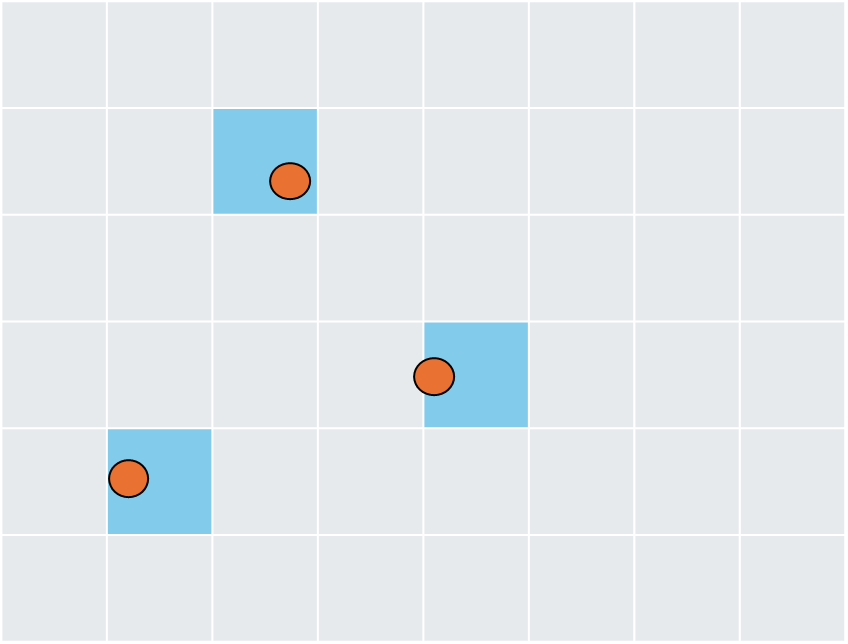

## What you'll learn: Extract and Interpolate Model Data

In this tutorial, you'll learn how to:
- **Extract point values** from gridded model data (HRRR, GFS, NAM, etc.)
- **Sample weather models** at specific latitude/longitude coordinates
- Work with both **regular grids** (lat/lon) and **curvilinear grids** (Lambert Conformal, polar stereographic)
- Use **nearest-neighbor** vs **distance-weighted interpolation** methods
- Create **time series** from model forecasts at station locations
- Extract **vertical profiles** (model soundings) at points
- **Interpolate GRIB2 data** to observation sites
- Optimize performance for extracting hundreds or thousands of points
- Cache spatial indices (BallTree) for faster repeated queries

### Common Use Cases
- Compare model output to weather station observations
- Extract forecast data for specific cities or locations
- Create model soundings at radiosonde sites
- Sample gridded forecasts along flight paths or trajectories
- Validate NWP models against point measurements
- Extract model data for machine learning training datasets

**Requirements:** This tutorial requires the `scikit-learn` package for spatial indexing:
```bash
pip install scikit-learn
# or install with all Herbie extras
pip install 'herbie-data[extras]'
```

## How it Works: Spatial Indexing with BallTree

Herbie uses **scikit-learn's BallTree algorithm** with the **haversine formula** for accurate nearest-neighbor queries on Earth's spherical surface. This approach works for any model grid projection without requiring coordinate transformations.

### Advantages over other methods:
- ✅ Works with **curvilinear/projected grids** (HRRR, NAM, WRF)
- ✅ Handles **longitude convention differences** (0-360° vs ±180°)
- ✅ Returns **distance to nearest grid points** (great-circle distance in km)
- ✅ Supports **k-nearest neighbors** for interpolation and uncertainty quantification
- ✅ **Fast queries** even for thousands of points
- ✅ No coordinate transformation required

## Background: When to Use Pick Points

For regular latitude-longitude grids (e.g., GFS, IFS), you could use xarray's [advanced indexing](https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing) to select your points of interest. However, `pick_points` is necessary when:

- **Curvilinear grids**: Models like HRRR use Lambert Conformal or other map projections
- **Longitude conventions differ**: Model uses [0, 360) but your points are in [-180, 180)
- **Distance matters**: You need to know how far the nearest grid point is from your location
- **Multiple neighbors**: You want k-nearest points for interpolation or statistics
- **Performance**: Extracting many points at once (spatial indexing is very fast)
- **Batch processing**: Repeatedly querying the same grid (BallTree caching)

<details>
<summary><b>Development History: Why I Built This</b></summary>

Picking values at nearest-neighbor points in a [curvilinear grid](https://en.wikipedia.org/wiki/Curvilinear_coordinates) has been one of my longstanding challenges. In November 2019, I asked [How to select the nearest lat/lon location with multi-dimension coordinates](https://stackoverflow.com/q/58758480/2383070) on Stack Overflow, which has had over 28k views. My initial solution found the minimum distance between points and grid cells, but it didn't scale well for many points.

I iterated through several approaches:

**Previous approach (deprecated):** `ds.herbie.nearest_points` used MetPy's [assign_y_x](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html?highlight=assign_y_x) to transform coordinates to the model's projection (e.g., Lambert Conformal for HRRR), then selected nearest neighbors. This worked but required Cartopy coordinate transformations, and not all datasets have sufficient projection metadata.

**Current approach:** Using BallTree with haversine distance:
- ✅ No coordinate transformation needed
- ✅ Can extract k-nearest neighbors
- ✅ Returns actual distances (km) using haversine formula
- ✅ Supports inverse-distance weighted interpolation
- ✅ Much faster for bulk queries

I later discovered the [xoak](https://xoak.readthedocs.io/) package, which also uses BallTree for nearest neighbors.

</details>

---

## Getting Started

To use Herbie's xarray accessors, just import Herbie (the accessor registers automatically):

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import herbie
from herbie import FastHerbie, Herbie

## A Very Simple Demonstration

First, I'll show how Herbie extracts nearest points from a simple grid. Let's make a 3x3 xarray Dataset with latitude/longitude coordinates and then extract data nearest two points of interest.


In [2]:
# Create a 3x3 xarray dataset
ds = xr.Dataset(
    {"a": (["latitude", "longitude"], [[0, 1, 2], [0, 1, 0], [0, 0, 0]])},
    coords={
        "latitude": (["latitude"], [44, 45, 46]),
        "longitude": (["longitude"], [-99, -100, -101]),
    },
)
ds

<xarray.Dataset> Size: 120B
Dimensions:    (latitude: 3, longitude: 3)
Coordinates:
  * latitude   (latitude) int64 24B 44 45 46
  * longitude  (longitude) int64 24B -99 -100 -101
Data variables:
    a          (latitude, longitude) int64 72B 0 1 2 0 1 0 0 0 0

The points you want to extract must be given as a Pandas DataFrame with columns `latitude` and `longitude` given in degrees.


In [3]:
# We want to pick data closest to two points
points = pd.DataFrame(
    {
        "longitude": [-100.25, -99.4],
        "latitude": [44.25, 45.4],
    }
)
points

,longitude,latitude
0,-100.25,44.25
1,-99.40,45.40


Now we can pick the nearest grid points with the custom Herbie xarray accessor.

> Note `method='nearest'` is the default behavior.


In [4]:
# Pick the value nearest the requested points
matched = ds.herbie.pick_points(points, method="nearest")
matched

         Provide tree_name parameter to enable caching.
INFO: 🌱 Growing new BallTree...🌳 Complete in 0.01s


<xarray.Dataset> Size: 96B
Dimensions:              (point: 2)
Coordinates:
    latitude             (point) int64 16B 44 45
    longitude            (point) int64 16B -100 -99
    point_grid_distance  (point) float64 16B 34.22 54.41
    point_longitude      (point) float64 16B -100.2 -99.4
    point_latitude       (point) float64 16B 44.25 45.4
Dimensions without coordinates: point
Data variables:
    a                    (point) int64 16B 1 0

Alternatively, we can get the inverse-distance weighted mean of the 4 nearest points.


In [5]:
# Distance weighted mean
matched_w = ds.herbie.pick_points(points, method="weighted")
matched_w

         Provide tree_name parameter to enable caching.
INFO: 🌱 Growing new BallTree...🌳 Complete in 0.00s


<xarray.Dataset> Size: 240B
Dimensions:              (point: 2, k: 4)
Coordinates:
    point_longitude      (point) float64 16B -100.2 -99.4
    point_latitude       (point) float64 16B 44.25 45.4
    latitude             (k, point) int64 64B 44 45 44 45 45 46 45 46
    longitude            (k, point) int64 64B -100 -99 -101 ... -99 -101 -100
    point_grid_distance  (k, point) float64 64B 34.22 54.41 66.0 ... 102.4 81.38
Dimensions without coordinates: point, k
Data variables:
    a                    (point) float64 16B 1.082 0.2588
Attributes:
    pick_point_method:  weighted
    pick_point_k:       4

### Understanding the Output

The returned Dataset includes several useful coordinates:
- `point_latitude`, `point_longitude`: Your requested coordinates
- `point_grid_distance`: Distance (km) to the nearest grid point
- `latitude`, `longitude`: The actual grid point coordinates
- Any additional columns from your points DataFrame (e.g., `point_stid`)

The `point` dimension indexes your requested points.

That's a lot of info to digest. Let's visualize what we have done with the following figure:


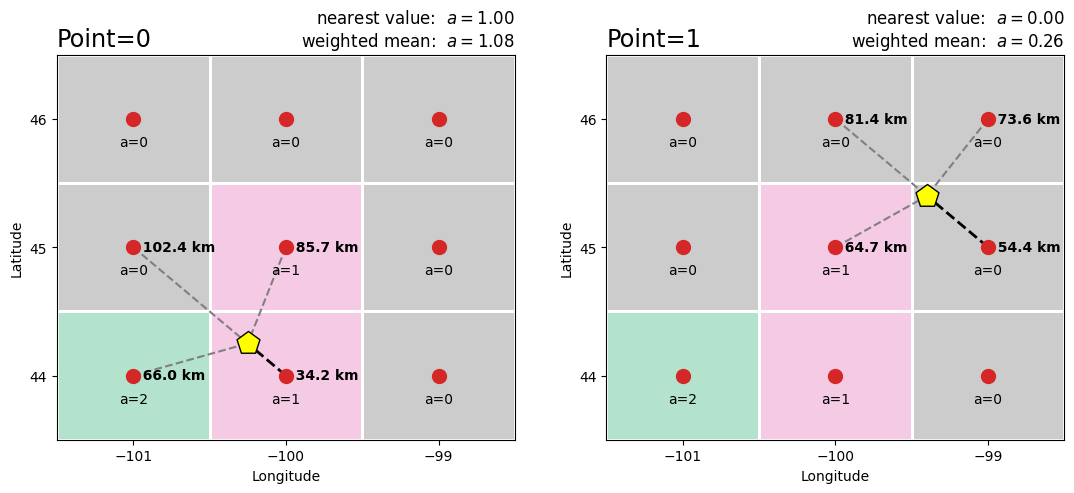

In [6]:
fig, axes = plt.subplots(1, 2, figsize=[13, 5])
for p, ax in zip(matched_w.point, axes):
    zz = matched.sel(point=p)

    # Plot grid
    ax.pcolormesh(
        ds.longitude, ds.latitude, ds.a, edgecolor="1", lw=1, cmap="Pastel2_r"
    )
    x, y = np.meshgrid(ds.longitude, ds.latitude)
    x = x.flatten()
    y = y.flatten()
    ax.scatter(x, y, facecolor="tab:red", edgecolor="tab:red", s=100, zorder=100)

    # Plot requested point
    ax.scatter(
        zz.point_longitude,
        zz.point_latitude,
        color="yellow",
        ec="k",
        marker="p",
        s=300,
        zorder=100,
    )
    for i in ds.latitude:
        for j in ds.longitude:
            z = ds.sel(latitude=i, longitude=j)
            ax.text(j, i, f"\na={z.a.item()}", ha="center", va="top")

    # Plot path to nearest point and distance
    # for i, j in zip(x, y):
    #    ax.plot([i, point.longitude.values[0]], [j, point.latitude.values[0]])
    for i in matched_w.k:
        if i == 0:
            kwargs = dict(lw=2, color="k", ls="--")
        else:
            kwargs = dict(color=".5", ls="--")
        z = matched_w.sel(k=i, point=p)
        ax.plot(
            [z.longitude, z.point_longitude], [z.latitude, z.point_latitude], **kwargs
        )
        ax.text(
            z.longitude,
            z.latitude,
            f"  {z.point_grid_distance.item():.1f} km",
            va="center",
            fontweight="bold",
        )
    ax.set_xticks(ds.longitude)
    ax.set_yticks(ds.latitude)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Point={p.item()}", loc="left", fontsize="xx-large")
    ax.set_title(
        f"nearest value:  $a={zz.a.item():.2f}$\nweighted mean:  $a={z.a.item():.2f}$",
        loc="right",
    )

The yellow pentagon is the requested point. The grid's nearest-neighbor point is connected by a thick dashed line. The three other nearest neighbors used to compute the distance-weighted mean are connected by a thin dashed line.

**Summary:** From a simple 2D Dataset with latitude and longitude coordinates, we got the nearest value for two points of interest. We also compute the inverse-distance weighted mean from the four grids nearest our point of interest.


## Pick points from HRRR data

The above is nice, but you might say, "Yeah, but you can already select data from a grid using [xarray advanced selection](https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing)." That is true, but it does not work for models with curvilienar grids, like the HRRR model.

Here is a demonstration using real HRRR data.


In [7]:
H = Herbie("2024-03-01", model="hrrr")
ds = H.xarray(":(?:TMP|DPT):2 m")
ds

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


<xarray.Dataset> Size: 46MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB 292.5 292.5 292.4 ... 266.8 266.8
    d2m                  (y, x) float32 8MB 287.3 287.2 287.2 ... 262.2 262.2
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    search:                  :(?:TMP|DPT):2 m

Let's extract the data from some points with some fruit-themed station id names.


In [8]:
points = pd.DataFrame(
    {
        "latitude": np.linspace(44, 45.5, 5),
        "longitude": np.linspace(-100, -101, 5),
        "stid": ["McIntosh", "Golden", "Fuji", "Gala", "Honeycrisp"],
    }
)
points

,latitude,longitude,stid
0,44.000,-100.00,McIntosh
1,44.375,-100.25,Golden
2,44.750,-100.50,Fuji
3,45.125,-100.75,Gala
4,45.500,-101.00,Honeycrisp


In [9]:
%%time
matched = ds.herbie.pick_points(points)
matched

CPU times: user 330 ms, sys: 414 ms, total: 744 ms
Wall time: 764 ms


<xarray.Dataset> Size: 320B
Dimensions:              (point: 5)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 40B 43.99 44.37 44.76 45.13 45.5
    longitude            (point) float64 40B 260.0 259.8 259.5 259.3 259.0
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
    point_grid_distance  (point) float64 40B 0.8515 1.07 1.611 1.41 1.318
    point_latitude       (point) float64 40B 44.0 44.38 44.75 45.12 45.5
    point_longitude      (point) float64 40B -100.0 -100.2 -100.5 -100.8 -101.0
    point_stid           (point) object 40B 'McIntosh' 'Golden' ... 'Honeycrisp'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 20B 288.0 286.7 286.1 282.3 284.8
    d2m                  (point) float32 20B 268.8 271.8 270.5 274.1 270.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    search:                  :(?:TMP|DPT):2 m

Notice that a BallTree object for the HRRR model was saved with the name `<model_name>_<x_dim>_<y_dim>.pkl` in the directory you save Herbie data. This is done so it can be loaded more quickly next time you extract points from this grid.

In the next cell I run the same command, and it uses the cached tree instead.


In [10]:
%%time
matched = ds.herbie.pick_points(points)
matched

CPU times: user 523 ms, sys: 241 ms, total: 764 ms
Wall time: 760 ms


<xarray.Dataset> Size: 320B
Dimensions:              (point: 5)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 40B 43.99 44.37 44.76 45.13 45.5
    longitude            (point) float64 40B 260.0 259.8 259.5 259.3 259.0
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
    point_grid_distance  (point) float64 40B 0.8515 1.07 1.611 1.41 1.318
    point_latitude       (point) float64 40B 44.0 44.38 44.75 45.12 45.5
    point_longitude      (point) float64 40B -100.0 -100.2 -100.5 -100.8 -101.0
    point_stid           (point) object 40B 'McIntosh' 'Golden' ... 'Honeycrisp'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 20B 288.0 286.7 286.1 282.3 284.8
    d2m                  (point) float32 20B 268.8 271.8 270.5 274.1 270.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    search:                  :(?:TMP|DPT):2 m

You may want to swap the dimensions to use the `point_stid` coordinate as the dimension instead. Doing this makes it possible to select data by station ID instead of point index.


In [11]:
matched = matched.swap_dims({"point": "point_stid"})
matched.sel(point_stid="Honeycrisp")

<xarray.Dataset> Size: 128B
Dimensions:              ()
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             float64 8B 45.5
    longitude            float64 8B 259.0
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
    point_grid_distance  float64 8B 1.318
    point_latitude       float64 8B 45.5
    point_longitude      float64 8B -101.0
    point_stid           <U10 40B 'Honeycrisp'
Data variables:
    t2m                  float32 4B 284.8
    d2m                  float32 4B 270.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    search:                  :(?:TMP|DPT):2 m

Now let's plot each point on a map with the value at the nearest grid point.


(-289442.889311017, -108684.3334160587, 605320.486730601, 849853.0858732163)

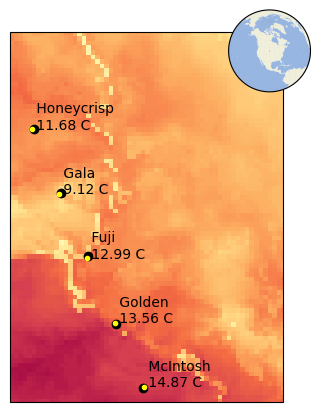

In [12]:
from herbie.toolbox import EasyMap, ccrs, pc

ax = EasyMap(crs=ds.herbie.crs).ax
ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.t2m,
    cmap="Spectral_r",
    vmax=290,
    vmin=270,
    transform=pc,
)

for i in matched.point_stid:
    z = matched.sel(point_stid=i)
    ax.scatter(z.longitude, z.latitude, color="k", transform=pc)
    ax.scatter(
        z.point_longitude, z.point_latitude, color="yellow", marker=".", transform=pc
    )
    ax.text(
        z.point_longitude,
        z.point_latitude,
        f" {z.point_stid.item()}\n {z.t2m.item() - 273.15:.2f} C",
        transform=pc,
    )
ax.set_extent([-101, -99, 44, 46], crs=pc)
ax.EasyMap.INSET_GLOBE()
ax.adjust_extent()

Here is another example with several cities

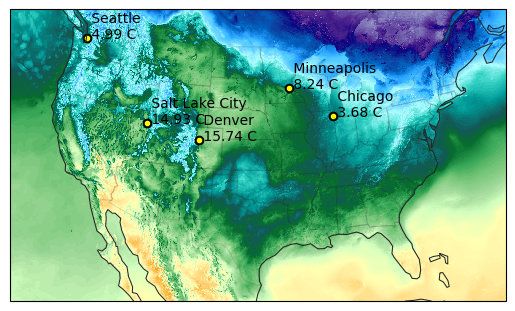

In [13]:
points = pd.DataFrame(
    {
        "latitude": [40.7608, 41.8781, 39.7392, 44.9778, 47.6062],
        "longitude": [-111.8910, -87.6298, -104.9903, -93.2650, -122.3321],
        "stid": ["Salt Lake City", "Chicago", "Denver", "Minneapolis", "Seattle"],
        "elevation": [1288, 182, 1655, 264, 56],  # Optional: add metadata
    }
)

# ---------------
# Pick the points
matched = ds.herbie.pick_points(points)

# -------------
# Make the plot

from herbie.paint import NWSTemperature

ax = EasyMap(crs=ds.herbie.crs).STATES().ax
ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.t2m - 273.15,
    **NWSTemperature.kwargs,
    transform=pc,
)

for i in matched.point:
    z = matched.sel(point=i)
    ax.scatter(z.longitude, z.latitude, color="k", transform=pc)
    ax.scatter(
        z.point_longitude, z.point_latitude, color="yellow", marker=".", transform=pc
    )
    ax.text(
        z.point_longitude,
        z.point_latitude,
        f" {z.point_stid.item()}\n {z.t2m.item() - 273.15:.2f} C",
        transform=pc,
    )


## Pick Points: Sounding

For vertical profiles, download all pressure levels and extract at a point. This creates a "model sounding" that can be compared to observations.


In [14]:
# TODO: Get real sounding data to compare model data to.

In [15]:
# Get all pressure level data
H = Herbie("2024-03-28 00:00", model="hrrr", product="prs")
ds = H.xarray("(?:DPT|TMP):[0-9]* mb", remove_grib=False)

slc_point = pd.DataFrame(
    {
        "latitude": [40.76],
        "longitude": [-111.876183],
        "stid": ["KSLC"],
    }
)

slc = ds.herbie.pick_points(slc_point)
slc

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


<xarray.Dataset> Size: 704B
Dimensions:              (isobaricInhPa: 39, point: 1)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 312B 1e+03 975.0 ... 75.0 50.0
    latitude             (point) float64 8B 40.75
    longitude            (point) float64 8B 248.1
    valid_time           datetime64[ns] 8B 2024-03-28
    gribfile_projection  object 8B None
    point_grid_distance  (point) float64 8B 1.193
    point_latitude       (point) float64 8B 40.76
    point_longitude      (point) float64 8B -111.9
    point_stid           (point) object 8B 'KSLC'
Dimensions without coordinates: point
Data variables:
    t                    (isobaricInhPa, point) float32 156B ...
    dpt                  (isobaricInhPa, point) float32 156B ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 prs
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240328/subset_0befd2f...
    search:                  (?:DPT|TMP):[0-9]* mb

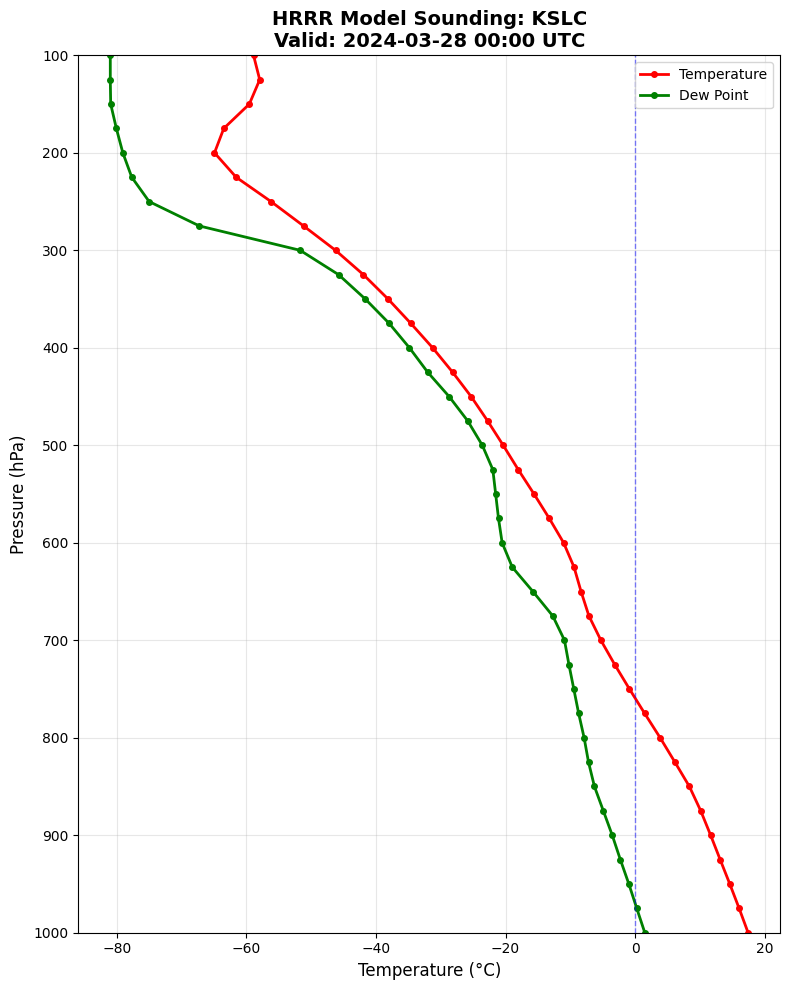

In [16]:
# Create a proper sounding plot
fig, ax = plt.subplots(figsize=(8, 10))

# Plot temperature and dewpoint
ax.plot(
    slc.t - 273.15,
    slc.isobaricInhPa,
    color="red",
    marker="o",
    linewidth=2,
    markersize=4,
    label="Temperature",
)
ax.plot(
    slc.dpt - 273.15,
    slc.isobaricInhPa,
    color="green",
    marker="o",
    linewidth=2,
    markersize=4,
    label="Dew Point",
)

# Format axes
ax.invert_yaxis()
ax.set_ylim(1000, 100)
ax.set_ylabel("Pressure (hPa)", fontsize=12)
ax.set_xlabel("Temperature (°C)", fontsize=12)
ax.set_title(
    f"HRRR Model Sounding: {slc.point_stid.item()}\n"
    f"Valid: {slc.valid_time.dt.strftime('%Y-%m-%d %H:%M UTC').item()}",
    fontsize=14,
    fontweight="bold",
)
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right")

# Add reference lines
ax.axvline(0, color="blue", linestyle="--", alpha=0.5, linewidth=1)
plt.tight_layout()


## Pick Points: Timeseries


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 09:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 15:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 18:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 21:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-02 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


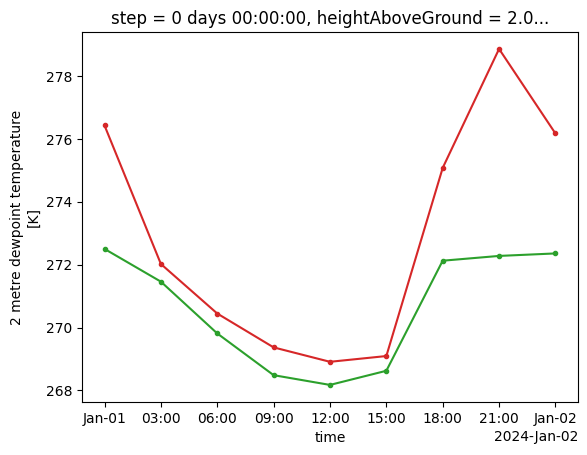

In [17]:
# TODO: Could demonstrate using FastHerbie here, if the kernel wouldn't crash (memory??)

i = []
for date in pd.date_range("2024-01-01", periods=9, freq="3h"):
    ds = Herbie(date).xarray("(?:DPT|TMP):2 m", remove_grib=False)
    i.append(
        ds.herbie.pick_points(
            pd.DataFrame(
                {
                    "latitude": [40.77069],
                    "longitude": [-111.96503],
                    "stid": ["KSLC"],
                }
            )
        )
    )
slc_ts = xr.concat(i, dim="valid_time")

slc_ts.t2m.plot(x="valid_time", marker=".", color="tab:red")
slc_ts.d2m.plot(x="valid_time", marker=".", color="tab:green")

## Benchmark

Let's benchmark picking different numbers of points to understand performance scaling when harvesting _many_ points.


In [18]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd

from herbie import Herbie
from herbie.toolbox import EasyMap, ccrs, pc

In [19]:
H = Herbie("2024-03-28 00:00", model="hrrr")
ds = H.xarray(r"TMP:\d* mb", remove_grib=False)


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


Using the model's own grid, I will generate 100 random samples to extract.


In [20]:
def generate_test_points(ds, n):
    """Generate n random points from the model grid."""
    import random
    import string

    points = (
        ds[["latitude", "longitude"]]
        .to_dataframe()[["latitude", "longitude"]]
        .sample(n)
        .reset_index(drop=True)
    )
    points["stid"] = [
        "".join(random.choices(string.ascii_letters, k=8)) for _ in range(n)
    ]
    return points


points_self_100 = generate_test_points(ds, 100)
points_self_100

,latitude,longitude,stid
0,29.718029,274.785946,SkNxqxCY
1,26.961634,255.333244,DONsGClt
2,47.380357,258.360720,zBYYWqvk
3,48.499379,236.466228,PNKRmpQX
4,37.763784,272.271894,kgiLfUwp
...,...,...,...
95,34.706803,275.869335,RrdbpPvj
96,25.423777,256.984473,ELGWpzoF
97,21.841066,285.435707,iSCwEgju
98,35.878342,285.655062,UQBJvXzT


In [21]:
%%timeit
y1 = ds.herbie.pick_points(points_self_100)

542 ms ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
y2 = ds.herbie.pick_points(points_self_100, method="weighted")

1.84 s ± 234 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit
# Try the deprecated `nearest_points` method which used MetPy
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y3 = ds.herbie.nearest_points(points_self_100)

541 ms ± 76.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
# Do I get the same answer for the old and new method?
y1 = ds.herbie.pick_points(points_self_100)
y2 = ds.herbie.pick_points(points_self_100, method="weighted")
y3 = ds.herbie.nearest_points(points_self_100)

all(y1.latitude == y3.latitude), all(y1.longitude == y3.longitude)

/home/blaylock/GITHUB/Herbie/src/herbie/nearest_points.py:109: UserWarning: More than one time coordinate present for variable  "t".
  ds = ds.metpy.assign_y_x()


(True, True)

CPU times: user 1.48 s, sys: 257 ms, total: 1.73 s
Wall time: 2.6 s


<GeoAxes: label='inset_axes'>

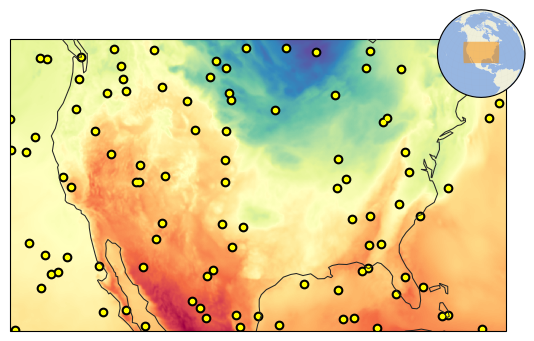

In [25]:
%%time
ax = EasyMap(crs=ds.herbie.crs).ax

ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.isel(isobaricInhPa=0).t,
    cmap="Spectral_r",
    transform=pc,
)

ax.scatter(y1.longitude, y1.latitude, color="k", transform=pc)
ax.scatter(
    y1.point_longitude, y1.point_latitude, color="yellow", marker=".", transform=pc
)

ax.EasyMap.INSET_GLOBE()

Not bad. Less than half a second to extract 100 points from the HRRR grid.

Now let's try _even more_...


✓ Completed 1 points
✓ Completed 3 points
✓ Completed 5 points
✓ Completed 7 points
✓ Completed 9 points
✓ Completed 10 points
✓ Completed 30 points
✓ Completed 50 points
✓ Completed 70 points
✓ Completed 90 points
✓ Completed 100 points
✓ Completed 300 points
✓ Completed 500 points
✓ Completed 700 points
✓ Completed 900 points
CPU times: user 1min, sys: 20.9 s, total: 1min 21s
Wall time: 1min 23s


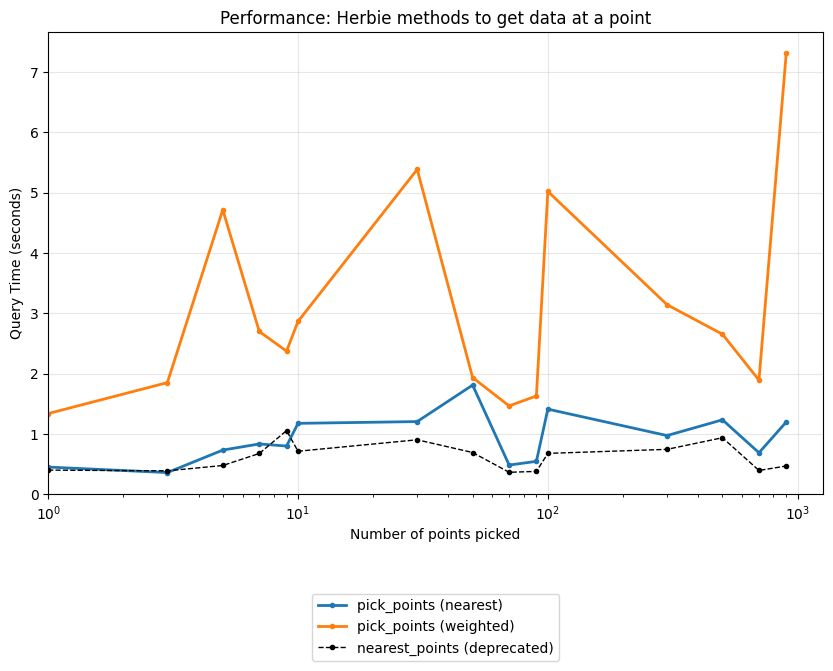

In [26]:
%%time

n_samples = (
    list(range(1, 10, 2)) + list(range(10, 100, 20)) + list(range(100, 1_000, 200))
    # + list(range(1_000, 10_000, 2_000))
    # + [100_000, 1_000_000]
)

times_pick_points_nearest = []
times_pick_points_weighted = []
times_nearest_points = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for n in n_samples:
        points = generate_test_points(ds, n)

        timer = pd.Timestamp("now")
        _ = ds.herbie.nearest_points(points)
        times_nearest_points.append((pd.Timestamp("now") - timer).total_seconds())

        timer = pd.Timestamp("now")
        _ = ds.herbie.pick_points(points, method="nearest")
        times_pick_points_nearest.append((pd.Timestamp("now") - timer).total_seconds())

        timer = pd.Timestamp("now")
        _ = ds.herbie.pick_points(points, method="weighted")
        times_pick_points_weighted.append((pd.Timestamp("now") - timer).total_seconds())

        print(f"✓ Completed {n:,} points")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    n_samples,
    times_pick_points_nearest,
    marker=".",
    lw=2,
    color="tab:blue",
    label="pick_points (nearest)",
)
ax.plot(
    n_samples,
    times_pick_points_weighted,
    marker=".",
    lw=2,
    color="tab:orange",
    label="pick_points (weighted)",
)
ax.plot(
    n_samples,
    times_nearest_points,
    marker=".",
    lw=1,
    color="k",
    ls="--",
    label="nearest_points (deprecated)",
)

ax.set_xscale("log")
ax.set_title("Performance: Herbie methods to get data at a point")
ax.set_xlabel("Number of points picked")
ax.set_ylabel("Query Time (seconds)")
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=1)
ax.grid(True, alpha=0.3)
ax.legend(loc="upper center", bbox_to_anchor=[0.5, -0.2])

Nice! This BallTree method used by `pick_points()` scales well for harvesting _many_ points 😎

Lets see how well this works for the GFS model...


In [27]:
gfs = Herbie("2024-01-01", model="gfs").xarray(":TMP:2 m ")

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


In [28]:
%%time
gfs.herbie.pick_points(points_self)

NameError: name 'points_self' is not defined

## Advanced Options

The default behavior for `method='nearest'` is to return the first nearest neighbor. The default behavior for `method='weighted'` is to return the inverse-distance weighted mean of the nearest 4 grid points.

You can get more or fewer neighbors by setting the `k` argument. This might be useful if you want to compute the standard deviation of the _k_ grid points surrounding a point of interest.


In [29]:
%%time

# Return the 5 nearest grid points to each request point
ds.herbie.pick_points(points_self_100, method="nearest", k=5)

CPU times: user 2.13 s, sys: 819 ms, total: 2.95 s
Wall time: 2.96 s


<xarray.Dataset> Size: 24kB
Dimensions:              (k: 5, isobaricInhPa: 5, point: 100)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 40B 1e+03 925.0 ... 700.0 500.0
    latitude             (k, point) float64 4kB 29.72 26.96 47.38 ... 35.9 45.11
    longitude            (k, point) float64 4kB 274.8 255.3 ... 285.7 294.9
    valid_time           datetime64[ns] 8B 2024-03-28
    gribfile_projection  object 8B None
    point_grid_distance  (k, point) float64 4kB 0.0 0.0 0.0 ... 2.997 2.979
    point_latitude       (point) float64 800B 29.72 26.96 47.38 ... 35.88 45.14
    point_longitude      (point) float64 800B 274.8 255.3 258.4 ... 285.7 294.9
    point_stid           (point) object 800B 'SkNxqxCY' ... 'KYvNRgCr'
Dimensions without coordinates: k, point
Data variables:
    t                    (k, isobaricInhPa, point) float32 10kB 293.1 ... 259.9
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240328/subset_0befe27...
    search:                  TMP:\d* mb

In [30]:
%%time
# Compute the distance weighted mean for the 9 nearest grid points to
# each request point
ds.herbie.pick_points(points_self_100, method="weighted", k=9)

CPU times: user 3.12 s, sys: 341 ms, total: 3.46 s
Wall time: 3.5 s


<xarray.Dataset> Size: 28kB
Dimensions:              (isobaricInhPa: 5, point: 100, k: 9)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 40B 1e+03 925.0 ... 700.0 500.0
    valid_time           datetime64[ns] 8B 2024-03-28
    gribfile_projection  object 8B None
    point_latitude       (point) float64 800B 29.72 26.96 47.38 ... 35.88 45.14
    point_longitude      (point) float64 800B 274.8 255.3 258.4 ... 285.7 294.9
    point_stid           (point) object 800B 'SkNxqxCY' ... 'KYvNRgCr'
    latitude             (k, point) float64 7kB 29.72 26.96 47.38 ... 35.91 45.1
    longitude            (k, point) float64 7kB 274.8 255.3 ... 285.6 294.9
    point_grid_distance  (k, point) float64 7kB 0.0 0.0 0.0 ... 4.238 4.213
Dimensions without coordinates: point, k
Data variables:
    t                    (isobaricInhPa, point) float64 4kB 293.1 ... 259.8
Attributes:
    pick_point_method:  weighted
    pick_point_k:       9

Suppose I wanted to calculate terrain roughness around each point using k-nearest neighbors by calculating the standard deviation of model surface height around each of my points.


In [31]:
ds = Herbie("2024-01-01").xarray("HGT:surface")
dsp = ds.herbie.pick_points(points_self_100, k=100)
dsp

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ local


<xarray.Dataset> Size: 282kB
Dimensions:              (k: 100, point: 100)
Coordinates:
    time                 datetime64[ns] 8B 2024-01-01
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
    latitude             (k, point) float64 80kB 29.72 26.96 ... 35.96 45.07
    longitude            (k, point) float64 80kB 274.8 255.3 ... 285.8 294.7
    valid_time           datetime64[ns] 8B 2024-01-01
    gribfile_projection  object 8B None
    point_grid_distance  (k, point) float64 80kB 0.0 0.0 0.0 ... 16.95 16.85
    point_latitude       (point) float64 800B 29.72 26.96 47.38 ... 35.88 45.14
    point_longitude      (point) float64 800B 274.8 255.3 258.4 ... 285.7 294.9
    point_stid           (point) object 800B 'SkNxqxCY' ... 'KYvNRgCr'
Dimensions without coordinates: k, point
Data variables:
    orog                 (k, point) float32 40kB 6.263 1.444e+03 ... 0.01339
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240101/subset_6bef832...
    search:                  HGT:surface

In [32]:
terrain_roughness = dsp.orog.std(dim="k")
terrain_roughness

<xarray.DataArray 'orog' (point: 100)> Size: 400B
array([3.74864864e+00, 7.70284042e+01, 3.17707424e+01, 1.59296356e+02,
       8.50554657e+00, 2.69303436e+02, 2.61035797e+02, 0.00000000e+00,
       7.76310120e+01, 1.48034021e-02, 3.39158669e+01, 1.53166565e+02,
       1.60940230e+00, 0.00000000e+00, 7.13127975e+01, 1.51575775e+01,
       6.64364319e+01, 0.00000000e+00, 1.12974800e+02, 0.00000000e+00,
       2.69054890e+00, 0.00000000e+00, 3.99752159e+01, 3.41971703e+01,
       6.46535950e+01, 3.35994232e+02, 1.60176880e+02, 1.26123024e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.03021851e+01,
       1.89539986e+01, 0.00000000e+00, 4.04688110e+01, 0.00000000e+00,
       0.00000000e+00, 4.26026802e+01, 0.00000000e+00, 6.81077968e-03,
       1.19178711e+02, 2.45614243e+01, 0.00000000e+00, 6.05588112e+01,
       1.23778839e+02, 1.43709764e+01, 1.18544037e+02, 1.87431240e+01,
       2.04521179e+02, 1.97443123e+01, 1.72476761e+02, 9.15527344e-05,
       0.00000000e+00, 1.38174944e+01, 2.12805542e+02, 2.74857578e+01,
       1.04479446e+01, 1.16316414e+02, 1.93214893e+01, 6.84824142e+01,
       1.96816833e+02, 5.76621933e+01, 0.00000000e+00, 2.23715057e+01,
       0.00000000e+00, 0.00000000e+00, 1.37994690e+02, 2.15656357e+01,
       5.08315516e+00, 0.00000000e+00, 0.00000000e+00, 3.51489334e+01,
       1.04980412e+01, 0.00000000e+00, 2.73795258e+02, 3.37753448e+02,
       1.87713989e+02, 2.93994026e+01, 0.00000000e+00, 0.00000000e+00,
       2.48333950e+01, 1.72831936e+01, 3.04587769e+02, 4.41159105e+00,
       2.12090187e+01, 4.74487686e+01, 1.65152624e-01, 0.00000000e+00,
       0.00000000e+00, 1.64283066e+01, 1.11062164e+02, 0.00000000e+00,
       4.81408958e+01, 0.00000000e+00, 1.59145447e+02, 1.24982613e+02,
       6.93545532e+01, 0.00000000e+00, 0.00000000e+00, 3.61904716e+01],
      dtype=float32)
Coordinates:
    time                 datetime64[ns] 8B 2024-01-01
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
    valid_time           datetime64[ns] 8B 2024-01-01
    gribfile_projection  object 8B None
    point_latitude       (point) float64 800B 29.72 26.96 47.38 ... 35.88 45.14
    point_longitude      (point) float64 800B 274.8 255.3 258.4 ... 285.7 294.9
    point_stid           (point) object 800B 'SkNxqxCY' ... 'KYvNRgCr'
Dimensions without coordinates: point

Text(0.5, 1.0, 'Terrain Variability from HRRR Model Elevation')

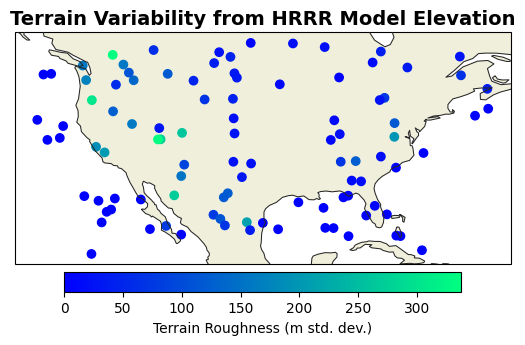

In [35]:
ax = EasyMap().LAND().ax

art = ax.scatter(
    terrain_roughness.point_longitude,
    terrain_roughness.point_latitude,
    c=terrain_roughness,
    cmap="winter",
)
plt.colorbar(
    art,
    ax=ax,
    label="Terrain Roughness (m std. dev.)",
    orientation="horizontal",
    pad=0.02,
    shrink=0.8,
)

ax.set_title(
    "Terrain Variability from HRRR Model Elevation", fontsize=14, fontweight="bold"
)